In this notebook, we are going to do some simple LSTM modeling of a time series. Of course this will be financial related and will the time series of SPY. 
A couple of things that I want to try: 
* Using the keras sequential API for creating a simple LSTM model
* Using the keras functional API to create a more sophisticated model which takes different types of input


In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# Keras imports for use later 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import plot_model

2023-06-30 00:12:09.410465: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 00:12:09.413531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 00:12:09.463123: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 00:12:09.464713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 00:12:10.053498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
spy = yf.download(tickers='SPY', progress=False)

In [3]:
# We are looking at the log returns of SPY
spy_log_close = spy['Adj Close'].apply(np.log)
log_returns = spy_log_close.diff()

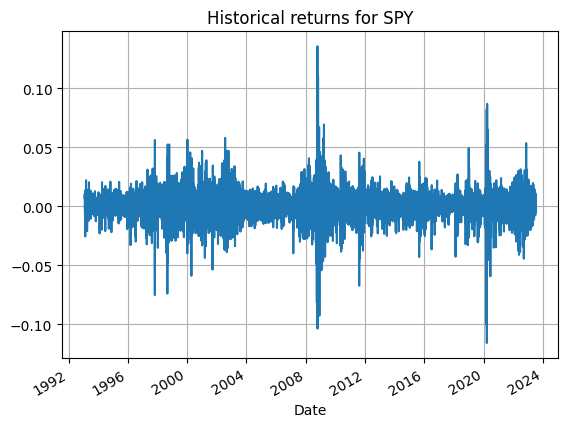

In [4]:
log_returns.plot()
plt.title("Historical returns for SPY")
plt.grid()
plt.show()

The type of model we will try is a simple LSTM model that uses the sequences of the past N days of returns to predict the next day's returns. We can also handle sequence to sequence modeling but we can use the individual return for now though. 

In [5]:
# Creating training, validation, and test data for this
target = log_returns.shift(-1)

In [6]:
all_data = pd.concat([log_returns, target], axis = 1).dropna()
all_data.columns = ['log_returns', 'target']

In [61]:
n_periods = 20
ts = all_data['log_returns'].copy(deep = True)

feature_array = np.array([ts.iloc[i:i+n_periods] for i in range(ts.shape[0]-n_periods+1)])

# Then we have to cut these now
target_array = all_data['target'].iloc[n_periods-1:].values

In [62]:
# Now that we have the array, we can split these into training, validation, and test data
features_train, features_test, targets_train, targets_test = train_test_split(
    feature_array, target_array, test_size=0.2, shuffle=False
)

In [63]:
val_size_pct = 0.2
val_size = int(features_train.shape[0] * val_size_pct)

In [64]:
features_validation = features_train[-val_size:]
targets_validation = targets_train[-val_size:]

features_train = features_train[:-val_size]
targets_train = targets_train[:-val_size]

Now that we have the features in training, validation, and testing. Let's set up our simple neural network model. One thing that I'd note is that we have not done any normalization or anything like that. We can do those in further improvements to our model. 

In [65]:
model = Sequential()
model.add(LSTM(units = 32, return_sequences=True, input_shape = (n_periods, 1)))
model.add(LSTM(units = 32, return_sequences=False))
model.add(Dense(units = 1, activation = 'linear')) 

# Then we compile this model
model.compile(
    optimizer = tf.keras.optimizers.Adam(), 
    loss = tf.keras.losses.MeanSquaredError(), 
    metrics = ['mse', 'mae']
)

2023-06-30 00:21:50.384704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 00:21:50.385533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 00:21:50.387123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 32)            4352      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


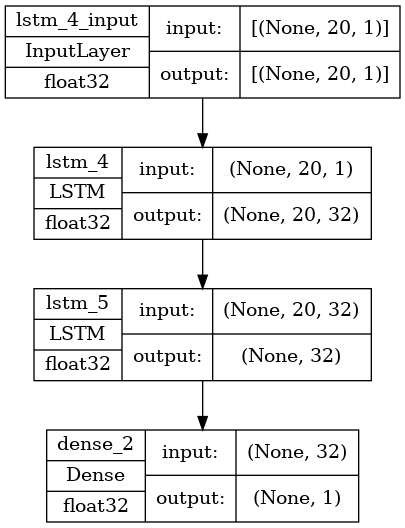

In [67]:
plot_model(model, "lstm_modeling_regression.png", show_dtype=True, show_shapes=True)

In [68]:
history = model.fit(
    x = features_train, 
    y = targets_train, 
    validation_data = (features_validation, targets_validation), 
    epochs = 30
)

Epoch 1/30


2023-06-30 00:21:58.283017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 00:21:58.285375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 00:21:58.287290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

153/153 [==============================] - ETA: 0s - loss: 1.6351e-04 - mse: 1.6351e-04 - mae: 0.0088

2023-06-30 00:22:02.276244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 00:22:02.277371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 00:22:02.279148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

153/153 [==============================] - 5s 16ms/step - loss: 1.6351e-04 - mse: 1.6351e-04 - mae: 0.0088 - val_loss: 6.0506e-05 - val_mse: 6.0506e-05 - val_mae: 0.0056
Epoch 2/30
153/153 [==============================] - 2s 13ms/step - loss: 1.5687e-04 - mse: 1.5687e-04 - mae: 0.0085 - val_loss: 6.1053e-05 - val_mse: 6.1053e-05 - val_mae: 0.0057
Epoch 3/30
153/153 [==============================] - 2s 13ms/step - loss: 1.5705e-04 - mse: 1.5705e-04 - mae: 0.0085 - val_loss: 6.0423e-05 - val_mse: 6.0423e-05 - val_mae: 0.0056
Epoch 4/30
153/153 [==============================] - 2s 13ms/step - loss: 1.5750e-04 - mse: 1.5750e-04 - mae: 0.0085 - val_loss: 7.2312e-05 - val_mse: 7.2312e-05 - val_mae: 0.0065
Epoch 5/30
153/153 [==============================] - 2s 13ms/step - loss: 1.5809e-04 - mse: 1.5809e-04 - mae: 0.0085 - val_loss: 6.0653e-05 - val_mse: 6.0653e-05 - val_mae: 0.0056
Epoch 6/30
153/153 [==============================] - 2s 13ms/step - loss: 1.5627e-04 - mse: 1.5627e-04 - 

In [69]:
history_df = pd.DataFrame(history.history)

<Axes: >

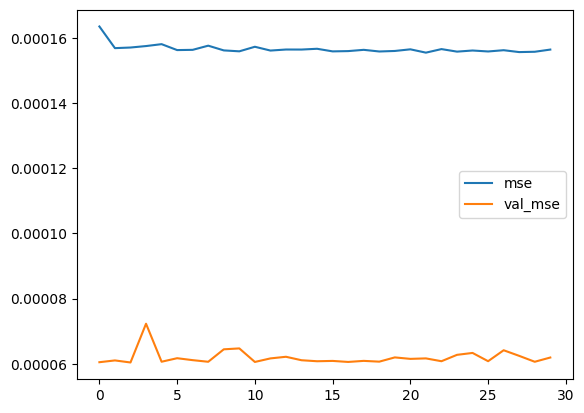

In [70]:
history_df[['mse', 'val_mse']].plot()

In [71]:
from sklearn.metrics import mean_squared_error

In [72]:
test_predictions = model.predict(features_test)

2023-06-30 00:23:06.852766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 00:23:06.854456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 00:23:06.855938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/48 [==============================] - 1s 4ms/step


In [73]:
mean_squared_error(targets_test, test_predictions.flatten())

0.00016162735896428645

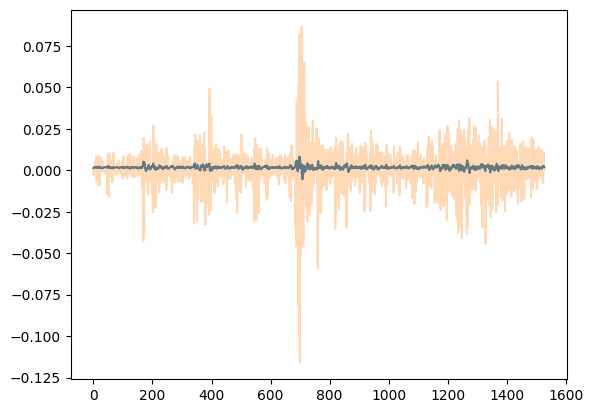

In [74]:
plt.plot(test_predictions)
plt.plot(targets_test, alpha = 0.3)

Conclusion: 

We set up a very quick and dirty LSTM model to try to predict the next return using some previous sequence of returns. When we look at the results, we do not see very good results I feel given that it can't pick up the magnitude in the returns at all. I think that this is a feature of not normalizing things. It's not picking up that there is conditional volatility that needs to be accounted for. This shows how the mean squared error is not super good here and does not tell the whole story. The mean absolute error can be huge here. 

Ways that we can improve on this: 
* Try out a combination model which takes other types of features such as conditonal volatility, technical indicators, etc. 
* Normalize the sequence of returns that is going into the LSTM model. That might help it a bit
* Try a classification problem maybe? Maybe it does better with that one 

We will investigate all of these things soon. 
